# Load external packages

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function
from collections import OrderedDict
import math
import torchvision.models as models
import torchvision.transforms as transforms
import pickle
import torch.autograd as autograd
import matplotlib.gridspec as gridspec
import h5py
from tqdm import tqdm
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import hyperspy.api as hs

In [ ]:
from os.path import join as pjoin
import glob as glob
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

# Implement Convolutional Autoencoder(CA) model structure

In [2]:
# Convolutional Block with 3 convolutional layers, 1 layer normalization layer with ReLU and ResNet 
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        """
         t_size: number of filters for in and out for each convulutional layer
         n_step: the position axis for layer normalization 
         
        """
        
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_4 = nn.ReLU()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)        
        out = self.cov1d_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)        
        out = self.relu_4(out)
        out = out.add(x_input)
        
        return out

In [3]:
# Identity Block with 1 convolutional layers, 1 layer normalization layer with ReLU 
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):        
        """
         t_size: number of filters for in and out for each convulutional layer
         n_step: the position axis for layer normalization 
         
        """
        
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)

        
        return out

In [4]:
# Encoder of the CA
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size):
        '''
         original_step_size: the x and y size of input image 
         pool_list: the list of parameter for each 2D MaxPool layer 
         embedding_size: the value for number of channels
         conv_size: the value of filters number goes to each block 
         
        '''
        super(Encoder,self).__init__()
        
        blocks = []
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')

        self.relu_1 = nn.ReLU()

        self.dense = nn.Linear(input_size,embedding_size)

        
    def forward(self,x):
        
        out = x.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = torch.flatten(out,start_dim=1)
        out = self.dense(out)    
        selection = self.relu_1(out)
        
        return selection

In [5]:
# Decoder of the CA
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size):
        '''
         original_step_size: the x and y size of input image 
         up_list: the list of parameter for each 2D Upsample layer 
         embedding_size: the value for number of channels
         conv_size: the value of filters number goes to each block 
        '''

        super(Decoder,self).__init__()
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        self.dense = nn.Linear(embedding_size,original_step_size[0]*original_step_size[1])
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        blocks = []
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        for i in range(number_of_blocks):
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]

        
    def forward(self,x):
        
        out = self.dense(x)
        out = out.view(-1,1,self.input_size_0,self.input_size_1)

        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        output = out.view(-1, self.output_size_0, self.output_size_1)
        
        return output

In [6]:
# Convolutional Autoencoder (CA)
class Joint(nn.Module):
    def __init__(self, enc, dec):
        """
         enc: encoder part
         dec: decoder part
         
        """
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        embedding= self.enc(x)

        predicted = self.dec(embedding)
        
        return predicted

# Regularizations to Loss function

$L = \frac{C}{2N} \sum\limits_{i=1}^{N} \left(\sum\limits_{j=1, j\neq i}^{N}cosine_similarity(latent_i, latent_j) - 1\right)$

$$L = \frac{cof1}{2N} \sum\limits_{i=1}^{N} \left(\sum\limits_{j=1, j\neq i}^{N}cosine_similarity(latent_i, latent_j) - 1\right)$$

$$L = \frac{cof1}{2N} \sum\limits_{i=1}^{N} \left(\sum\limits_{j=1, j\neq i}^{N} \frac{latent_i \cdot latent_j}{\left\lVert latent_i \right\rVert \left\lVert latent_j \right\rVert} - 1\right)$$

$$L = \frac{1}{B} \sum\limits_{i=1}^{B} \left(\frac{cof1}{2} \sum\limits_{j=1}^{n} \sum\limits_{k=j+1}^{n} \left| latent_{i,j} - latent_{i,k} \right|\right)$$

## Contrastive Similarity Regularization

In [7]:
class contrastive_loss(nn.Module):
    def __init__(self,cof1=1e-2):
        super(contrastive_loss,self).__init__()
        '''
         cof1: the coeiffient value mutiplied by regularization
         
        '''
        self.cof1 = cof1
        
    def to(self, device):
        self.device = device
        super().to(device)
        return self
    
    def forward(self,latent):
        loss = 0
        beyond_0 = torch.where(torch.sum(latent,axis=1)!=0)[0]
        new_latent = latent[beyond_0]
        for i in beyond_0:
            loss += sum(F.cosine_similarity(latent[i].unsqueeze(0),new_latent))-1
            
        loss = self.cof1*loss/(2.0*latent.shape[0])
        
        return loss 

## Activate Divergence Regularization

In [8]:
class maximum_loss(nn.Module):
    def __init__(self,batch_size,cof1=1e-2):
        super(maximum_loss,self).__init__()
        """
         batch_size: the batch value for each time loss updating
         coef1: the coeiffient value mutiplied by regularization
        
        """
        self.batch_size = batch_size
        self.cof1 = cof1
        
    def to(self, device):
        self.device = device
        super().to(device)
        return self
    
    def forward(self,latent):
        loss = 0
        for i in range(self.batch_size):
            no_zero = torch.where(latent[i].squeeze()!=0)[0]
            single = latent[i][no_zero]
            
            loss += self.cof1* torch.sum(abs(single.reshape(-1,1)-single))/2.0
            
        loss = loss/self.batch_size 
        
        return loss 

# The functions for generating Generators and for model training

## Generateor class

In [9]:
printing = {'PNG':True,
            'EPS':False, 
           'dpi': 300}


class generator:
    
    def __init__(self, 
                 model,
                 scaled_data,
                 embedding_out,
                 image, 
                 channels = None,
                 color_map = 'viridis'):
        
        self.model = model
        self.image = image
        
        # defines the colorlist
        
        self.cmap = plt.get_cmap(color_map)
        
            
        def predictor(values): 
                values = torch.from_numpy(np.atleast_2d(values))
                values = model(values.float())
                values = values.detach().numpy()
                
                return values
            
        self.embeddings = embedding_out
        self.predict = predictor
        self.vector_length = scaled_data.shape[1]
        if channels == None:
            self.channels = range(self.embeddings.shape[1])
        else: 
            self.channels = channels
        

    def generator_images(self, 
                        folder, 
                        ranges = None,
                        number_of_loops = 200, 
                        averaging_number = 100,
                        graph_layout = [2,2], 
                        y_lim = [-2,12],
                        xlabel = '',
                        ylabel = '',
                        xvalues = None,
                        in_radon=False
                        ):
        
        folder = make_folder(folder)
        max_value = -10
        min_value  = 10
        
        for i in tqdm(range(number_of_loops)):

            # builds the figure
            fig, ax = plt.subplots(graph_layout[0] // graph_layout[1] + (graph_layout[0] % graph_layout[1] > 0), graph_layout[1],
                                   figsize=(3 * graph_layout[1], 3 * (graph_layout[0] // graph_layout[1] + (graph_layout[0] % graph_layout[1] > 0))))
            ax = ax.reshape(-1)

            # loops around all of the embeddings
            for j, channel  in enumerate(self.channels):
                
                # checks if the value is None and if so skips tp next iteration
                if i is None:
                    continue
                    
                if xvalues is None:
                    xvalues = range(self.vector_length)
                
                if ranges is None: 
                    ranges =  np.stack((np.min(self.embeddings,axis=0),
                              np.max(self.embeddings,axis=0)), axis=1)

                # linear space values for the embeddings
                value = np.linspace(ranges[j][0], ranges[j][1], 
                                    number_of_loops)

                # finds the nearest point to the value and then takes the average
                # average number of points based on the averaging number
                idx = find_nearest(
                    self.embeddings[:,channel], 
                    value[i], 
                    averaging_number)
                
                # computes the mean of the selected index
                gen_value = np.mean(self.embeddings[idx], axis=0)
                
                # specifically updates the value of the embedding to visualize based on the
                # linear spaced vector
                gen_value[channel] = value[i]

                # generates the loop based on the model
                generated = self.predict(gen_value).squeeze()
                min_ = np.min(generated)
                max_ = np.max(generated)
                if min_<min_value:
                    min_value = min_
                    
                if max_>max_value:
                    max_value = max_
                

                # plots the graph
                if in_radon==True:
                    generated = iradon(generated)
        
                ax[j].imshow(generated,clim=[0,6])
                ax[j].plot(3,3, marker='o', markerfacecolor=self.cmap((i + 1) / number_of_loops))
                

                # formats the graph
                ax[j].set_xlabel(xlabel)

                # gets the position of the axis on the figure
                pos = ax[j].get_position()

                # plots and formats the binary cluster map
                axes_in = plt.axes([pos.x0-0.10 , pos.y1, .12 * 4, .12 * 4])

                # plots the imagemap and formats
                axes_in.imshow(self.embeddings[:, channel].reshape(self.image.shape[0:2]), clim=ranges[j])
                axes_in.set_yticklabels('')
                axes_in.set_xticklabels('')

            ax[0].set_ylabel(ylabel)

            savefig(, printing)
            plt.close(fig)

## Function for generating the folder

In [10]:
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

## Function for find nearest value in image

In [11]:
def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image
    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find
    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

## Function for saving the figure

In [12]:
def savefig(filename, printing):

    """
    function that saves the figure

    :param filename: path to save file
    :type filename: string
    :param printing: contains information for printing
                     'dpi': int
                            resolution of exported image
                      print_EPS : bool
                            selects if export the EPS
                      print_PNG : bool
                            selects if print the PNG
    :type printing: dictionary

    """


    # Saves figures at EPS
    if printing['EPS']:
        plt.savefig(filename + '.eps', format='eps',
                    dpi=printing['dpi'], bbox_inches='tight')

    # Saves figures as PNG
    if printing['PNG']:
        plt.savefig(filename + '.png', format='png',
                    dpi=printing['dpi'], bbox_inches='tight')

## Function for generating graphs

In [13]:
def layout_fig(graph, mod=None):
    """
    Sets the layout of graphs in matplotlib in a pretty way based on the number of plots
    Parameters
    ----------
    graphs : int
        number of axes to make
    mod : int (optional)
        sets the number of figures per row
    Returns
    -------
    fig : matplotlib figure
        handel to figure being created.
    axes : numpy array (axes)
        numpy array of axes that are created.
    """
    print(graph)

    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7
       
    mod = graph//2
            
    mod =int(mod)
    graph = int(graph)

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)

## Functions for generating movies

In [14]:
def make_movie(movie_name, input_folder, output_folder, file_format,
                            fps, output_format = 'mp4', reverse = False):

    """
    Function which makes movies from an image series

    Parameters
    ----------
    movie_name : string
        name of the movie
    input_folder  : string
        folder where the image series is located
    output_folder  : string
        folder where the movie will be saved
    file_format  : string
        sets the format of the files to import
    fps  : numpy, int
        frames per second
    output_format  : string, optional
        sets the format for the output file
        supported types .mp4 and gif
        animated gif create large files
    reverse : bool, optional
        sets if the movie will be one way of there and back
    """

    # searches the folder and finds the files
    file_list = glob.glob('./' + input_folder + '/*.' + file_format)

    # Sorts the files by number makes 2 lists to go forward and back
    list.sort(file_list)
    file_list_rev = glob.glob('./' + input_folder + '/*.' + file_format)
    list.sort(file_list_rev,reverse=True)

    # combines the file list if including the reverse
    if reverse:
        new_list = file_list + file_list_rev
    else:
        new_list = file_list


    if output_format == 'gif':
        # makes an animated gif from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_gif(output_folder + '/{}.gif'.format(movie_name), fps=fps)
    else:
        # makes and mp4 from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_videofile(output_folder + '/{}.mp4'.format(movie_name), fps=fps)

## Loss Function

In [15]:
def loss_function(model,
                  encoder,
                  decoder,
                  train_iterator,
                  optimizer,
                  coef = 0, 
                  coef1 = 0,
                  coef2 = 0,
                  ln_parm = 1):

    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
    con_l = contrastive_loss(coef1).to(device)
    #    for i, x in enumerate(train_iterator):
    for x in tqdm(train_iterator, leave=True, total=len(train_iterator)):
        
        x = x.to(device, dtype=torch.float)
        
        maxi_ = maximum_loss(x.shape[0],coef2).to(device)

        # update the gradients to zero
        optimizer.zero_grad()
        
        
        if beta is None: 
        
          embedding = encoder(x)
        
        else:
        
          embedding,sd,mn = encoder(x)
        

        reg_loss_1 = coef * torch.norm(embedding, ln_parm).to(device)/x.shape[0]
        
        if reg_loss_1 == 0:
            
            reg_loss_1 = 0.5

        predicted_x = decoder(embedding)
        
        contras_loss = con_l(embedding)
        maxi_loss = maxi_(embedding)
        # reconstruction loss
        loss = F.mse_loss(x, predicted_x, reduction='mean')

        
        loss = loss +  reg_loss_1 + contras_loss - maxi_loss 
            
        
        # backward pass
        train_loss += loss.item()
        loss.backward()
        # update the weights
        optimizer.step()

    return train_loss

## Train Function

In [16]:
def Train(encoder, decoder, join, optimizer,
          learning_rate = 3e-5,
          max_learning_rate = 1e-4,
          coef_1=0,
          coef_2=0,
          coef_3=0,
          seed = 12,
          epochs=100,
          with_scheduler=True,
          ln_parm=1, 
          epoch_ = None, 
          folder_path='.', 
          best_train_loss= None):
    
        torch.manual_seed(seed)
        train_iterator = DataLoader(log_data, batch_size=32, shuffle=True)
        
        if with_scheduler:
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=max_learning_rate,
                                                  step_size_up=15,cycle_momentum=False)
        else:
            scheduler = None
        
        
    
        N_EPOCHS = epochs
        if best_train_loss == None:
            best_train_loss = float('inf')

        if epoch_==None:
            start_epoch = 0
        else:
            start_epoch = epoch_+1

        for epoch in range(start_epoch,N_EPOCHS):

            train = loss_function(join,encoder,decoder,train_iterator,
                                  optimizer,coef_1,coef_2,coef_3,ln_parm)
            train_loss = train
            train_loss /= len(train_iterator)

            print('.............................')
            
          #  schedular.step()
            if best_train_loss > train_loss:
                best_train_loss = train_loss
                patience_counter = 1
                checkpoint = {
                    "net": join.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    "epoch": epoch,
                    "encoder": encoder.state_dict(), 
                    'decoder': decoder.state_dict(),
#                    'start_coef': coef,
                }
                if epoch >=0:
                    lr_ = format(optimizer.param_groups[0]['lr'],'.5f')
                    file_path = folder_path + '/Weight_'+\
                                f'epoch:{epoch:04d}_l1coef:{coef_1:.4f}'+'_lr:'+lr_+\
                                f'_trainloss:{train_loss:.4f}.pkl'
                    torch.save(checkpoint, file_path)

            if scheduler!= None:
                scheduler.step()


## Train Function

# Initialize CA model

## Set Parameters go to the model

In [17]:
en_original_step_size=[256,256]
pool_list=[4,4,2]
de_original_step_size = [8,8]
up_list = [2,4,4]
embedding_size=32
conv_size =128

## Generate model function 

In [18]:
# set device to load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

In [19]:
def make_model(en_original_step_size = en_original_step_size, 
               pool_list = pool_list, 
               de_original_step_size = de_original_step_size,
               up_list = up_list,
               embedding_size = embedding_size,
               conv_size = conv_size,
               device = device,
               learning_rate = 3e-5,
               ):
    encoder = Encoder(original_step_size=en_original_step_size,
                      pool_list=pool_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size).to(device)
    decoder = Decoder(original_step_size=de_original_step_size,
                      up_list=up_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size).to(device)
    join = Joint(encoder,decoder).to(device)
    
    optimizer = optim.Adam(join.parameters(), lr=learning_rate)
    
    return encoder, decoder, join, optimizer

# $Er(Ti, Mn)O_3$ 4D-STEM near ferroelectric vortex 

## Load the dataset

In [20]:
s = hs.load("/home/ferroelectric/data/SED_256x256x12_30x30_alpha3_NBD_spot0p5nm_CL12cm_vortex.hspy", reader="hspy", lazy=False)

/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


## Preprocess the dataset using Log function

In [21]:
raw_data = s.data
log_data = np.log(raw_data+1).reshape(-1,256,256)

In [22]:
log_data.shape

(65536, 256, 256)

In [23]:
mean_diff = np.mean(log_data,axis=0)

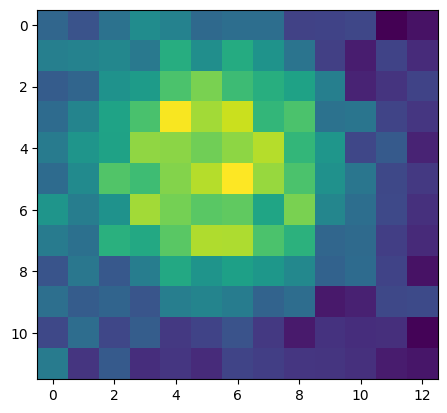

In [24]:
plt.imshow(mean_diff[150:162,152:165])

## Visualization

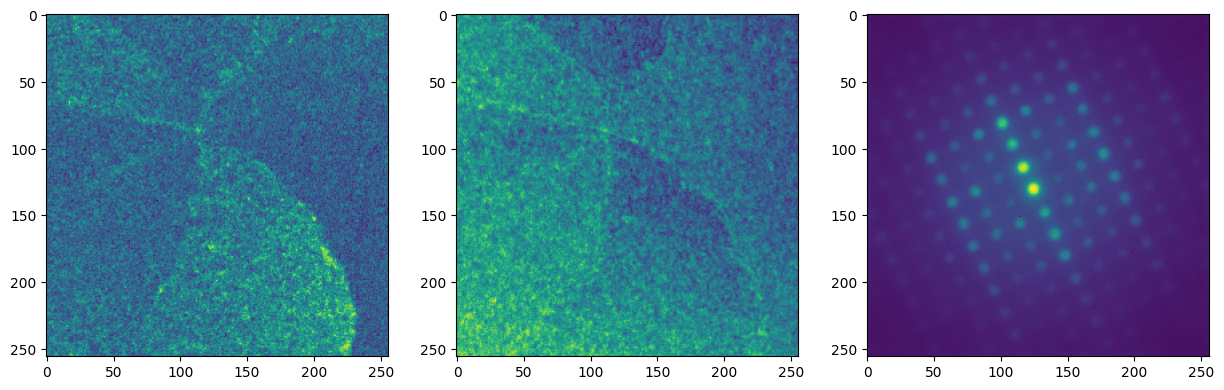

In [25]:
# visulization
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(np.mean(log_data[:,150:162,152:165].reshape(65536,-1),axis=1).reshape(256,256))
ax[1].imshow(np.mean(log_data.reshape(65536,-1),axis=1).reshape(256,256))
ax[2].imshow(np.mean(log_data,axis=0))

# Generate the embedding and Generator of Figure 4 e,f

In [30]:
encoder, decoder, join, optimizer = make_model(learning_rate = 3e-5)
beta = None

## Training the model from begining

In [31]:
# set retrain parameter
retrain_para = True
folder_path = make_folder('save_weight_figure4e_f')
if retrain_para:
    Train(encoder, decoder, join, optimizer,
          coef_1=5e-3,
          coef_2=5e-5,
          coef_3=2e-4,
          epochs=18,
          folder_path=folder_path)

  2%|▏         | 45/2048 [00:37<28:00,  1.19it/s]


KeyboardInterrupt: 

## Directly Load the Pretrained weights

In [ ]:
if not retrain_para:
    
    path_checkpoint = "./11.1_log_epoch_0017_L1loss_0.00181_l1coef_0.0050_lr_0.00009_contrasPara_0.000050_contrasLoss_0.00020_maxiPara_0.00070_maxiLoss_0.0019_trainloss_0.2289.pkl"

    checkpoint = torch.load(path_checkpoint)  
    join.load_state_dict(checkpoint['net'])
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    optimizer.load_state_dict(checkpoint['optimizer']) 
    start_epoch = checkpoint['epoch'] 

## Visualize the result

### Generating the embedding

In [ ]:
batch_size=64
train_iterator = DataLoader(log_data, batch_size=batch_size,
                        shuffle=False)

In [ ]:
embedding_ = np.zeros([65536,32])
recreate_input = np.zeros([65536,256,256])
j = 0
for i, x in enumerate(tqdm(train_iterator,leave=True,total = len(train_iterator))):
    with torch.no_grad():
        value = x
        test_value = Variable(value.cuda())
        test_value = test_value.float()
        embedding = encoder(test_value).to('cpu').detach().numpy()
        embedding_[i*batch_size:(i+1)*batch_size,:] = embedding
        
        ith_output = join(test_value).to('cpu').detach().numpy()
        recreate_input[i*batch_size:(i+1)*batch_size,:] = ith_output
#        print(f'the training process is ...{100*i/len(train_iterator):.2f}%')
        j=j+1
print(j)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [11:19<00:00,  1.51it/s]

1024


## Visualization of good, medium and bad case for recreation

In [ ]:
diff = np.mean(abs(log_data-recreate_input).reshape(65536,-1),axis=1)

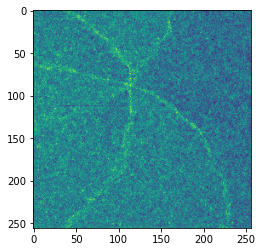

In [ ]:
plt.imshow(diff.reshape(256,256))

In [ ]:
diff[0:10]

array([0.40851889, 0.40907686, 0.40795965, 0.40789869, 0.40827568,
       0.40931409, 0.40827536, 0.40896309, 0.41167959, 0.40914466])

In [ ]:
sort_index = np.argsort(diff)

In [ ]:
sort_index[0:10]

array([61663, 36280, 38118, 37846,  4846,  1259, 28719, 45890, 19599,
       16050])

In [ ]:
65536/2

32768.0

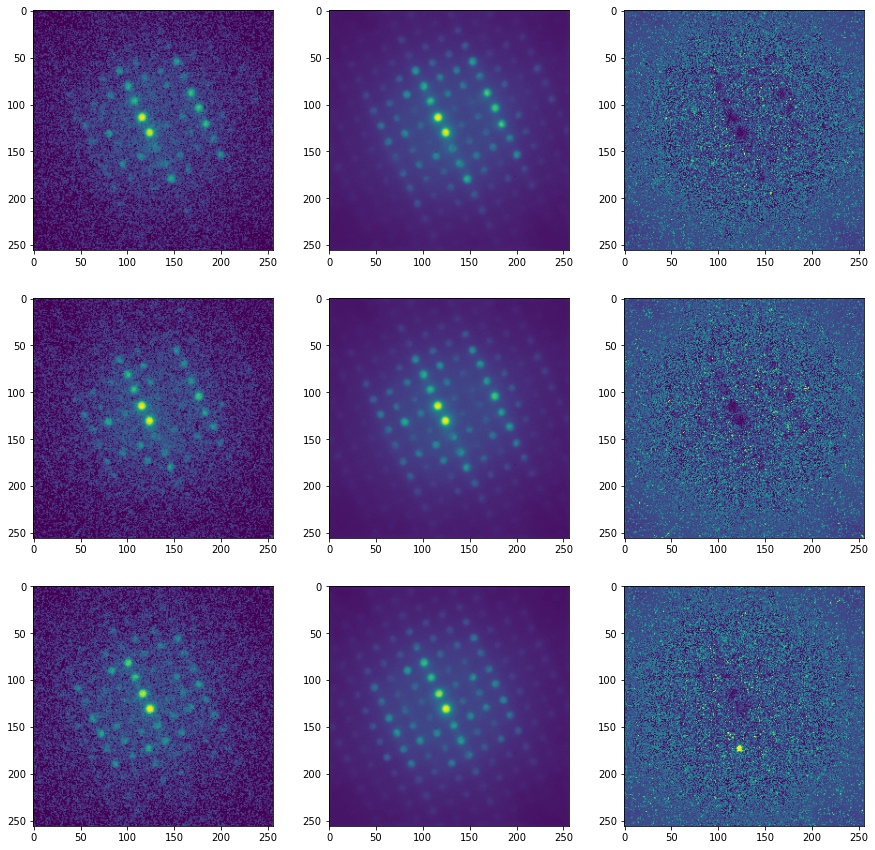

In [ ]:
fig,ax=plt.subplots(3,3,figsize=(15,15))
for i in range(3):
    if i==0:
        k=sort_index[0]
    elif i==1:
        k=sort_index[32767]
    else:
        k=sort_index[65535]
    ax[i][0].imshow(log_data[k])
    ax[i][1].imshow(recreate_input[k])
    ax[i][2].imshow(abs(log_data[k]-recreate_input[k]),clim=[0,1.5])

### Set the parameter for generator

In [ ]:
channels = [0,2]
ranges=[[0,0.025],[0,0.04]]
image = np.zeros([256,256])
folder_name = 'Generator_of_Figure_4_e_f'
decoder.to('cpu')

### Create the image for the movie

In [ ]:
generator_4d_maker = generator(decoder,image,embedding_, 
                                image, channels=channels)

In [ ]:
generator_4d_maker.generator_images(folder = folder_name, 
                                 number_of_loops=200,averaging_number=1,ranges = ranges)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:33<00:00,  1.31it/s]

6.0478897
-0.08064746


### Generate the movie 

In [ ]:
make_movie(folder_name,
           folder_name,
           folder_name,
          'png',
          3)

Moviepy - Building video Generator_of_Figure_4_e_f/Generator_of_Figure_4_e_f.mp4.
Moviepy - Writing video Generator_of_Figure_4_e_f/Generator_of_Figure_4_e_f.mp4



Moviepy - Done !
Moviepy - video ready Generator_of_Figure_4_e_f/Generator_of_Figure_4_e_f.mp4


# Generate the embedding and Generator of Figure 4b and reverse domain

In [ ]:
encoder, decoder, join, optimizer = make_model(learning_rate = 3e-5)

## Training the model from begining

In [ ]:
# set retrain parameter
retrain_para = False
folder_path = make_folder('save_weight_figure4b')
if retrain_para:
    
    Train(encoder, decoder, join, optimizer,
          coef_1=1e-5,
          epochs=225,
          with_scheduler=False,
          folder_path=folder_path)
    
    Train(encoder, decoder, join, optimizer,
          max_learning_rate = 5e-5,
          coef_1=5e-4,
          epochs=286,
          epoch_=224,
          folder_path=folder_path)

## Directly Load the Pretrained weights

In [ ]:
if not retrain_para:
    path_checkpoint = "./4.5_log_epoch:0285_L1loss:0.0001__lr:0.00003_trainloss:0.2279.pkl" 
    checkpoint = torch.load(path_checkpoint)  

    join.load_state_dict(checkpoint['net'])
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    optimizer.load_state_dict(checkpoint['optimizer']) 
    start_epoch = checkpoint['epoch']

## Visualize the result

### Generating the embedding

In [ ]:
embedding_ = np.zeros([65536,32])
j = 0
for i, x in enumerate(tqdm(train_iterator,leave=True,total = len(train_iterator))):
    with torch.no_grad():
        value = x
        test_value = Variable(value.cuda())
        test_value = test_value.float()
        embedding = encoder(test_value).to('cpu').detach().numpy()
        embedding_[i*batch_size:(i+1)*batch_size,:] = embedding
#        print(f'the training process is ...{100*i/len(train_iterator):.2f}%')
        j=j+1
print(j)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [03:43<00:00,  4.58it/s]

1024


### Set the parameter for generator

In [ ]:
channels=[13,31]
ranges=[[0,0.0225],[0,0.03]]
folder_name = 'Generator_of_Figure_4_b_and_Reverse'

### Create the image for the movie

In [ ]:
generator_4d_maker = generator(decoder,image,embedding_, 
                                image, channels=channels)

In [ ]:
generator_4d_maker.generator_images(folder = folder_name, 
                                 number_of_loops=200,averaging_number=1,ranges = ranges)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:40<00:00,  1.24it/s]

5.9674983
-0.099777564


### Generate the movie

In [ ]:
make_movie(folder_name,
           folder_name,
           folder_name,
          'png',
          3)

Moviepy - Building video Generator_of_Figure_4_b_and_Reverse/Generator_of_Figure_4_b_and_Reverse.mp4.
Moviepy - Writing video Generator_of_Figure_4_b_and_Reverse/Generator_of_Figure_4_b_and_Reverse.mp4



Moviepy - Done !
Moviepy - video ready Generator_of_Figure_4_b_and_Reverse/Generator_of_Figure_4_b_and_Reverse.mp4


# $Er(Ti, Mn)O_3$ 4D-STEM with a distinct polarization distortion along the crystallographic [001] direction

## Load the dataset

In [ ]:
s = hs.load("256p_3w_step1k4_a5_cl12_50ms_nmf_4.hspy", reader="hspy", lazy=False)

## Preprocess the dataset using Log function

In [ ]:
raw_data = s.data

In [ ]:
log_data = np.log(raw_data+1).reshape(-1,256,256)

# Generate the embedding and Generator of Figure 4 a, d

In [ ]:
encoder, decoder, join, optimizer = make_model(learning_rate = 3e-5)

## Training the model from begining

In [ ]:
# set retrain parameter
retrain_para = False
folder_path = make_folder('save_weight_figure4a_d')
if retrain_para:
    Train(encoder, decoder, join, optimizer,
          coef_1=1e-5,
          epochs=377,
          with_scheduler=False,
          folder_path=folder_path)

## Directly load the Pretrained weights

In [ ]:
if not retrain_para:
    path_checkpoint = "./11.23_log_epoch:0376_coef:1e-05_trainloss:0.1362.pkl" 
    checkpoint = torch.load(path_checkpoint)  

    join.load_state_dict(checkpoint['net'])
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    optimizer.load_state_dict(checkpoint['optimizer']) 
    start_epoch = checkpoint['epoch']

## Visualize the result

### Generating the embedding

In [ ]:
batch_size=64
train_iterator = DataLoader(log_data, batch_size=batch_size,
                        shuffle=False)

In [ ]:
embedding_ = np.zeros([65536,32])
j = 0
for i, x in enumerate(tqdm(train_iterator,leave=True,total = len(train_iterator))):
    with torch.no_grad():
        value = x
        test_value = Variable(value.cuda())
        test_value = test_value.float()
        embedding = encoder(test_value).to('cpu').detach().numpy()
        embedding_[i*batch_size:(i+1)*batch_size,:] = embedding
#        print(f'the training process is ...{100*i/len(train_iterator):.2f}%')
        j=j+1
print(j)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [03:43<00:00,  4.59it/s]

1024


### Set the parameter for generator

In [ ]:
channels = [20,29]
ranges=[[0,0.018],[0,0.022]]
folder_name = 'Generator_of_Figure_4_a_d'

### Create the image for the movie

In [ ]:
generator_4d_maker = generator(decoder,image,embedding_, 
                                image, channels=channels)

In [ ]:
generator_4d_maker.generator_images(folder = folder_name, 
                                 number_of_loops=200,averaging_number=1,ranges = ranges)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:47<00:00,  1.19it/s]

5.7449436
-0.09119637


### Generate the movie 

In [ ]:
make_movie(folder_name,
           folder_name,
           folder_name,
          'png',
          3)

Moviepy - Building video Generator_of_Figure_4_a_d/Generator_of_Figure_4_a_d.mp4.
Moviepy - Writing video Generator_of_Figure_4_a_d/Generator_of_Figure_4_a_d.mp4



Moviepy - Done !
Moviepy - video ready Generator_of_Figure_4_a_d/Generator_of_Figure_4_a_d.mp4
